[Weather Data](https://www.kaggle.com/datasets/prasad22/weather-data)


# LOAD ETL


In [1]:
import pandas as pd
from sqlalchemy import create_engine
import yaml
import psycopg2

Load file weather_data.csv

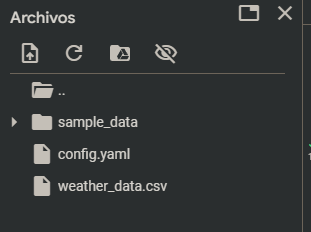

Create file config.yaml :


```
database:
  url:  "your db url supabase"
  user: "postgres.user"  
  password: "your password"  
  name: "postgres"
  port: 5432
  table: "table name"
```



Example :   postgresql://postgres.[user]:[YOUR-PASSWORD]@[url]:5432/postgres

In [2]:
def load_config(file_path="/content/config.yaml"):
    with open(file_path, "r") as file:
        return yaml.safe_load(file)

In [3]:
config = load_config()
db_config = config["database"]

# Charge credentials
SUPABASE_URL = db_config["url"]
DB_USER = db_config["user"]
DB_PASSWORD = db_config["password"]
DB_NAME = db_config["name"]
DB_PORT = db_config["port"]
TABLE_NAME = db_config["table"]



In [4]:
# Create conection to DB supabase
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{SUPABASE_URL}:{DB_PORT}/{DB_NAME}")

# Cargar el archivo CSV
csv_file = "/content/weather_data.csv"
df = pd.read_csv(csv_file)

# Display the first 5 rows
df.head(5)


,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622


In [5]:
# last 5 rows
df.tail(5)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
999995,Dallas,2024-01-01 20:29:48,23.416877,37.705024,3.819833,16.538119
999996,San Antonio,2024-01-20 15:59:48,6.759080,40.731036,8.182785,29.005558
999997,New York,2024-04-14 08:30:09,15.664465,62.201884,3.987558,0.403909
999998,Chicago,2024-05-12 20:10:43,18.999994,63.703245,4.294325,6.326036
999999,New York,2024-04-16 16:11:52,10.725351,43.804584,1.883292,15.363828


In [6]:
# Read the CSV into a DataFrame, only take first 11000 rows
df = pd.read_csv(csv_file, nrows=11000)

# last 5 rows
df.tail(5)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
10995,San Jose,2024-01-21 01:22:18,26.610890,87.424733,7.197925,5.749313
10996,Dallas,2024-03-07 11:37:08,28.178715,86.330654,2.093757,10.659999
10997,San Jose,2024-01-19 01:03:35,38.268248,66.925891,3.060138,17.813180
10998,San Jose,2024-04-23 18:56:54,19.845844,36.820104,3.341647,14.061083
10999,San Diego,2024-02-05 11:08:00,23.833778,81.874137,8.119941,13.543413


In [7]:
# Display the first 5 rows
df.head(5)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622


In [10]:
#Know the type of data in the column
df.dtypes

,0
Location,object
Date_Time,object
Temperature_C,float64
Humidity_pct,float64
Precipitation_mm,float64
Wind_Speed_kmh,float64


In [11]:
# Create connection with psycopg2 to execute SQL
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=SUPABASE_URL,
    port=DB_PORT
)
cursor = conn.cursor()

# Generate table structure
columns = []
for col, dtype in zip(df.columns, df.dtypes):
    if "int" in str(dtype):
        sql_type = "INTEGER"
    elif "float" in str(dtype):
        sql_type = "FLOAT"
    elif "bool" in str(dtype):
        sql_type = "BOOLEAN"
    else:
        sql_type = "TEXT"
    columns.append(f'"{col}" {sql_type}')

# Create table in PostgreSQL if it does not exist
create_table_query = f'''
CREATE TABLE IF NOT EXISTS {TABLE_NAME} (
   id SERIAL PRIMARY KEY,
    {", ".join(columns)}
);
'''
cursor.execute(create_table_query)
conn.commit()

# Close cursor and connection
cursor.close()
conn.close()

# Upload data to Supabase
df.to_sql(TABLE_NAME, engine, if_exists="append", index=False)

print(f"Table '{TABLE_NAME}' created and data successfully inserted into Supabase.")


Table 'weather' created and data successfully inserted into Supabase.


Read DB

In [13]:
# Read data from Supabase
df = pd.read_sql(f"SELECT * FROM {TABLE_NAME}", engine)
# Display the first 5 rows
df.head(5)

,id,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,1,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,2,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,3,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,4,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,5,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622
